In [ ]:
import numpy as np
import h5py
import tensorflow as tf

def normalize_events(events):
    # Separate amplitude and time features
    amplitude = events[..., 0]  # Shape (2850, 60, 32, 32)
    time = events[..., 1]  # Shape (2850, 60, 32, 32)
    
    # Normalize amplitude independently for each event
    amplitude_min = amplitude.min(axis=(1, 2, 3), keepdims=True)
    amplitude_max = amplitude.max(axis=(1, 2, 3), keepdims=True)
    amplitude_normalized = (amplitude - amplitude_min) / (amplitude_max - amplitude_min)
    
    # Normalize time independently for each event
    time_min = time.min(axis=(1, 2, 3), keepdims=True)
    time_max = time.max(axis=(1, 2, 3), keepdims=True)
    time_normalized = (time - time_min) / (time_max - time_min)
    
    # Combine the normalized amplitude and time back into the events array
    normalized_events = np.stack([amplitude_normalized, time_normalized], axis=-1)  # Shape (2850, 60, 32, 32, 2)
    
    return normalized_events

# Normalize truths independently
def normalize_truths(truths):
    truths_max = truths.max(axis=(1, 2, 3), keepdims=True)
    return truths / truths_max


# Load data
with h5py.File('/home/filippo/DUNE/data/numu-CC-QE/lightweight_dataset.h5', 'r') as f:
    events = f['inputs'][:]    # Load all inputs into memory
    truths = f['targets'][:]   # Load all targets into memory

# ----------------------------
# 1. Normalize inputs to [0, 1]
# ----------------------------
normalized_events = events
normalized_truths = normalize_truths(truths)
# Inputs: (N, 60)
X = normalized_events

# Targets: (N, 2, 4, 5) with values in [0, 1]
y = normalized_truths

# ---- Build the model ----
input_dim = 60
output_shape = (2, 4, 5)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(np.prod(output_shape), activation='sigmoid'),
    tf.keras.layers.Reshape(output_shape)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

# ---- Train the model ----

history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

2025-05-23 14:36:52.522813: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 14:36:52.966431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748003813.124332   37899 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748003813.168973   37899 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 14:36:53.563523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

AxisError: axis 1 is out of bounds for array of dimension 1

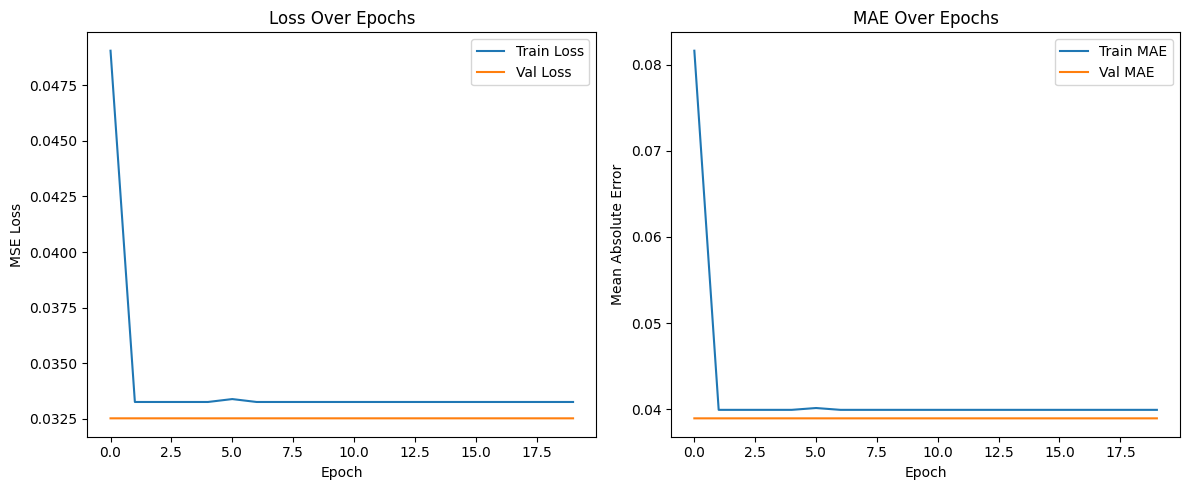

In [ ]:
import matplotlib.pyplot as plt

# ---- Plot loss curves ----

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', lw=2)
plt.plot(history.history['val_loss'], label='Val Loss', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()